In [9]:
%matplotlib inline

import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
from cselect import color as cs
import sys
sys.path.insert(0,'../')
sys.path.insert(0,'../samples')
from mvpose.data import epfl_campus
from time import time

root = Settings['data_root']
#root = join(root, 'pak')
tmp = Settings['tmp']

import mvpose.data.kth_football2 as kth
from mvpose import pose
from mvpose.settings import get_settings
from paf_loader import Loader
from mvpose.evaluation import pcp

loader = Loader()

# ----------------------------
def extract_best_kth(pos3d, Humans):
    """
        Extracts the best fitting human for the calculation
    """
    alpha = 0.5
    larms = 0
    uarms = 0
    ulegs = 0
    llegs = 0
    all_parts = 0
    
    for h in Humans:
        r = pcp.evaluate(pos3d, Humans[0], alpha)
        if all_parts < r.all_parts:
            larms = r.lower_arms
            uarms = r.upper_arms
            ulegs = r.upper_legs
            llegs = r.lower_legs
    
    return np.mean([larms, uarms, ulegs, llegs])

def generate_pcp_score_kth(frame, params):
    # default
    global Settings
    data_root = Settings['data_root']
    seq1_zipname = 'player2sequence1.zip'
    seq1_dir = 'Sequence 1'
    Im, Calib, pos2d, pos3d = kth.get(
        data_root, seq1_zipname, seq1_dir, frame, player=2)
    heatmaps, pafs = loader.load_confidence_map_and_paf(
        'kth' + seq1_zipname[0:-4], Im, frame, dir=Settings['tmp'])
    detections = pose.estimate(Calib, heatmaps, pafs, 
                           settings=params)
    
    if len(detections) == 0:
        return 0
    
    Humans = kth.transform3d_from_mscoco(detections)
    return extract_best_kth(pos3d, Humans)
    


ms radius  420
frame 000/043
frame 050/043
frame 100/043
frame 150/043
frame 200/043
	elapsed 40.79294037818909
	result: 0.9331395348837209


ms radius  440
frame 000/043
frame 050/043
frame 100/043
frame 150/043
frame 200/043
	elapsed 38.43670701980591
	result: 0.9244186046511628


ms radius  460
frame 000/043
frame 050/043
frame 100/043
frame 150/043
frame 200/043
	elapsed 38.022727489471436
	result: 0.9244186046511628


ms radius  480
frame 000/043
frame 050/043
frame 100/043
frame 150/043
frame 200/043
	elapsed 39.559401750564575
	result: 0.9215116279069767


ms radius  500
frame 000/043
frame 050/043
frame 100/043
frame 150/043
frame 200/043
	elapsed 37.585187911987305
	result: 0.9215116279069767


ms_radius_results [0.9331395348837209, 0.9244186046511628, 0.9244186046511628, 0.9215116279069767, 0.9215116279069767]




In [ ]:
#ms_radius = [10, 20, 30, 50, 60, 70, 90, 100, 120, 150, 170, 200, 250,
#            240, 260, 270, 280, 300]
ms_radius_results = []
ms_radius = [420, 440, 460, 480, 500]

# ====== RADIUS =======
for ms in ms_radius:
    print('\nms radius ', ms)
    _start = time()
    params = get_settings(scale_to_mm=1000,
                      min_nbr_joints=5,
                      max_epi_distance=25,
                      hm_detection_threshold=0.05,
                      pp_conflict_overlap=0.4,
                      min_joint_distance=20,
                      gp_max_radius=300,
                      ms_radius=ms,
                      ms_between_distance=60)

    valid_frames = list(range(0, 214, 5))
    #valid_frames = [0, 1, 2]
    scores = []
    for frame in valid_frames:
        score = generate_pcp_score_kth(frame, params)
        if frame % 50 == 0:
            print('frame %03d/%03d' %(frame, len(valid_frames)))
        scores.append(score)
    ms_radius_results.append(np.mean(scores))
    _end = time()
    print('\telapsed', _end - _start)
    print('\tresult:', np.mean(scores))
    print('')

print('\nms_radius_results', ms_radius_results)
print('\n')

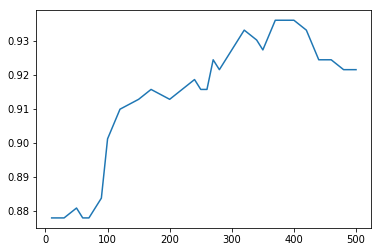

In [11]:
ms_radius = [
    10,   20,  30,  50,  60,  70,  90, 100, 
    120, 150, 170, 200, 240, 250, 260, 270, 
    280, 300] + [320, 340, 350, 370, 400] +\
    [420, 440, 460, 480, 500]
ms_radius_results = [
    0.877906976744186, 0.877906976744186, 
    0.877906976744186, 0.8808139534883721, 
    0.877906976744186, 0.877906976744186, 
    0.8837209302325582, 0.9011627906976745, 
    0.9098837209302325, 0.9127906976744186, 
    0.9156976744186046, 0.9127906976744186, 
    0.9186046511627907, 0.9156976744186046, 
    0.9156976744186046, 0.9244186046511628, 
    0.9215116279069767, 0.9273255813953488] + [
    0.9331395348837209, 0.9302325581395349, 
    0.9273255813953488, 0.936046511627907, 
    0.936046511627907] + [
    0.9331395348837209, 0.9244186046511628, 
    0.9244186046511628, 0.9215116279069767, 
    0.9215116279069767
]
plt.plot(ms_radius, ms_radius_results)
plt.show()

In [13]:
# ====== DETECTION THRESHOLD =======

hm_detection_thresholds = [0.01, 0.03, 0.05, 0.1, 0.2, 0.3, 0.4]
hm_detection_thresholds_results = []

for th in hm_detection_thresholds:
    print('\nms detection threshold ', th)
    _start = time()
    params = get_settings(scale_to_mm=1000,
                      min_nbr_joints=5,
                      max_epi_distance=25,
                      hm_detection_threshold=th,
                      pp_conflict_overlap=0.4,
                      min_joint_distance=20,
                      gp_max_radius=300,
                      ms_radius=60,
                      ms_between_distance=60)

    valid_frames = list(range(0, 214, 5))
    #valid_frames = [0, 1, 2]
    scores = []
    for frame in valid_frames:
        score = generate_pcp_score_kth(frame, params)
        if frame % 50 == 0:
            print('frame %03d/%03d' %(frame, len(valid_frames)))
        scores.append(score)
    hm_detection_thresholds_results.append(np.mean(scores))
    _end = time()
    print('\telapsed', _end - _start)
    print('\tresult:', np.mean(scores))
    print('')

print('\nms_radius_results', hm_detection_thresholds_results)
print('\n')


ms detection threshold  0.01
frame 000/043
frame 050/043
frame 100/043
frame 150/043
frame 200/043
	elapsed 871.2968294620514
	result: 0.8924418604651163


ms detection threshold  0.03
frame 000/043
frame 050/043
frame 100/043
frame 150/043
frame 200/043
	elapsed 195.16891145706177
	result: 0.8691860465116279


ms detection threshold  0.05
frame 000/043
frame 050/043
frame 100/043
frame 150/043
frame 200/043
	elapsed 149.1772379875183
	result: 0.877906976744186


ms detection threshold  0.1
frame 000/043
frame 050/043
frame 100/043
frame 150/043
frame 200/043
	elapsed 173.55382633209229
	result: 0.8691860465116279


ms detection threshold  0.2
frame 000/043
frame 050/043
frame 100/043
frame 150/043
frame 200/043
	elapsed 55.13203263282776
	result: 0.8575581395348837


ms detection threshold  0.3
frame 000/043
frame 050/043
frame 100/043
frame 150/043
frame 200/043
	elapsed 34.62493300437927
	result: 0.8023255813953488


ms detection threshold  0.4
frame 000/043
frame 050/043
frame 100

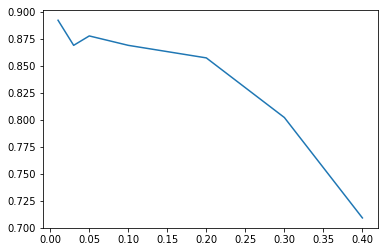

In [14]:
hm_detection_thresholds = [0.01, 0.03, 0.05, 0.1, 0.2, 0.3, 0.4]
ms_radius_results = [0.8924418604651163, 0.8691860465116279, 0.877906976744186, 0.8691860465116279, 0.8575581395348837, 0.8023255813953488, 0.7093023255813954]

plt.plot(hm_detection_thresholds, ms_radius_results)
plt.show()

In [15]:
# ====== CONFLICT =======

pp_conflict_overlap = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.9]
pp_conflict_overlap_results = []

for th in pp_conflict_overlap:
    print('\nms conflict threshold ', th)
    _start = time()
    params = get_settings(scale_to_mm=1000,
                      min_nbr_joints=5,
                      max_epi_distance=25,
                      hm_detection_threshold=0.05,
                      pp_conflict_overlap=th,
                      min_joint_distance=20,
                      gp_max_radius=300,
                      ms_radius=60,
                      ms_between_distance=60)

    valid_frames = list(range(0, 214, 5))
    #valid_frames = [0, 1, 2]
    scores = []
    for frame in valid_frames:
        score = generate_pcp_score_kth(frame, params)
        if frame % 50 == 0:
            print('frame %03d/%03d' %(frame, len(valid_frames)))
        scores.append(score)
    pp_conflict_overlap_results.append(np.mean(scores))
    _end = time()
    print('\telapsed', _end - _start)
    print('\tresult:', np.mean(scores))
    print('')

print('\nms_radius_results', pp_conflict_overlap_results)
print('\n')


ms detection threshold  0.1
frame 000/043
frame 050/043
frame 100/043
frame 150/043
frame 200/043
	elapsed 137.10871577262878
	result: 0.877906976744186


ms detection threshold  0.2
frame 000/043
frame 050/043
frame 100/043
frame 150/043
frame 200/043
	elapsed 166.22947025299072
	result: 0.877906976744186


ms detection threshold  0.3
frame 000/043
frame 050/043
frame 100/043
frame 150/043
frame 200/043
	elapsed 146.36742186546326
	result: 0.877906976744186


ms detection threshold  0.4
frame 000/043
frame 050/043
frame 100/043
frame 150/043
frame 200/043
	elapsed 83.5450394153595
	result: 0.877906976744186


ms detection threshold  0.5
frame 000/043
frame 050/043
frame 100/043
frame 150/043
frame 200/043
	elapsed 90.87382388114929
	result: 0.877906976744186


ms detection threshold  0.6
frame 000/043
frame 050/043
frame 100/043
frame 150/043
frame 200/043
	elapsed 62.61542057991028
	result: 0.877906976744186


ms detection threshold  0.9
frame 000/043
frame 050/043
frame 100/043
fra

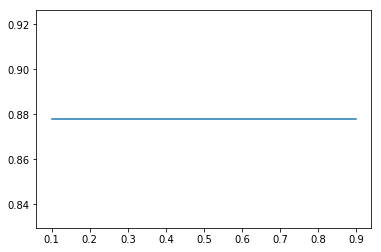

In [16]:
pp_conflict_overlap = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.9]
pp_conflict_overlap_results = [0.877906976744186, 0.877906976744186, 0.877906976744186, 0.877906976744186, 0.877906976744186, 0.877906976744186, 0.877906976744186]
plt.plot(pp_conflict_overlap, pp_conflict_overlap_results)
plt.show()

In [18]:
# ====== epidistance =======

#max_epi_distance = [1, 5, 10, 15, 20, 50, 100]
max_epi_distance = [150, 200, 300]
# epi distance [0.0029069767441860465, 0.3691860465116279, 0.752906976744186, 0.8197674418604651, 0.8517441860465116, 0.8982558139534884, 0.9069767441860465]
max_epi_distance_results = []

for epi in max_epi_distance:
    print('\nms epi distance ', epi)
    _start = time()
    params = get_settings(scale_to_mm=1000,
                      min_nbr_joints=5,
                      max_epi_distance=epi,
                      hm_detection_threshold=0.05,
                      pp_conflict_overlap=0.4,
                      min_joint_distance=20,
                      gp_max_radius=300,
                      ms_radius=60,
                      ms_between_distance=60)

    valid_frames = list(range(0, 214, 5))
    #valid_frames = [0, 1, 2]
    scores = []
    for frame in valid_frames:
        score = generate_pcp_score_kth(frame, params)
        if frame % 50 == 0:
            print('frame %03d/%03d' %(frame, len(valid_frames)))
        scores.append(score)
    max_epi_distance_results.append(np.mean(scores))
    _end = time()
    print('\telapsed', _end - _start)
    print('\tresult:', np.mean(scores))
    print('')

print('\nepi distance', max_epi_distance_results)
print('\n')


ms epi distance  150
frame 000/043
frame 050/043
frame 100/043
frame 150/043
frame 200/043
	elapsed 6707.982254981995
	result: 0.9011627906976745


ms epi distance  200
frame 000/043


KeyboardInterrupt: 

In [21]:
# ====== intersection =======

min_joint_distance = [1, 5, 10, 15, 20, 50, 100, 150, 200, 300]
# epi distance [0.0029069767441860465, 0.3691860465116279, 0.752906976744186, 0.8197674418604651, 0.8517441860465116, 0.8982558139534884, 0.9069767441860465]
min_joint_distance_results = []

for d in min_joint_distance:
    print('\nmin joint distance', d)
    _start = time()
    params = get_settings(scale_to_mm=1000,
                      min_nbr_joints=5,
                      max_epi_distance=25,
                      hm_detection_threshold=0.05,
                      pp_conflict_overlap=0.4,
                      min_joint_distance=d,
                      gp_max_radius=300,
                      ms_radius=60,
                      ms_between_distance=60)

    valid_frames = list(range(0, 214, 5))
    #valid_frames = [0, 1, 2]
    scores = []
    for frame in valid_frames:
        score = generate_pcp_score_kth(frame, params)
        if frame % 50 == 0:
            print('frame %03d/%03d' %(frame, len(valid_frames)))
        scores.append(score)
    min_joint_distance_results.append(np.mean(scores))
    _end = time()
    print('\telapsed', _end - _start)
    print('\tresult:', np.mean(scores))
    print('')

print('\nmin joint distance', min_joint_distance_results)
print('\n')


min joint distance 1
frame 000/043
frame 050/043
frame 100/043
frame 150/043
frame 200/043
	elapsed 154.16108536720276
	result: 0.877906976744186


min joint distance 5
frame 000/043
frame 050/043
frame 100/043
frame 150/043
frame 200/043
	elapsed 60.53231406211853
	result: 0.877906976744186


min joint distance 10
frame 000/043
frame 050/043
frame 100/043
frame 150/043
frame 200/043
	elapsed 59.83187747001648
	result: 0.875


min joint distance 15
frame 000/043
frame 050/043
frame 100/043
frame 150/043
frame 200/043
	elapsed 60.069451093673706
	result: 0.875


min joint distance 20
frame 000/043
frame 050/043
frame 100/043
frame 150/043
frame 200/043
	elapsed 59.13611888885498
	result: 0.877906976744186


min joint distance 50
frame 000/043
frame 050/043
frame 100/043
frame 150/043
frame 200/043
	elapsed 80.55852055549622
	result: 0.8837209302325582


min joint distance 100
frame 000/043
frame 050/043
frame 100/043
frame 150/043
frame 200/043
	elapsed 59.868854999542236
	result: 0.87